In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
cars = pd.read_csv('divar_cars_cat_price.csv', index_col=0)
print(cars.shape)
cars.head()

(103799, 39)


image_count   mileage  price_cat   age  city_Ahvaz  city_Isfahan  \
0            0  290000.0          0  14.0           0             0   
1            3  175000.0          1  23.0           0             0   
2            4   80000.0          2   4.0           0             0   
3            3  125000.0          0  11.0           0             0   
4            2   11000.0          1   2.0           0             0   

   city_Karaj  city_Kermanshah  city_Mashhad  city_Qom  ...  \
0           1                0             0         0  ...   
1           0                0             0         0  ...   
2           0                0             0         0  ...   
3           0                0             0         0  ...   
4           0                0             0         0  ...   

   brand_Pickup truck  brand_Pride  brand_RD/ROA  brand_Renault  brand_Runna  \
0                   0            0             0              0            0   
1                   0            0             0              0            0   
2                   0            0             0              0            0   
3                   0            0             0              0            0   
4                   0            0             0              0            0   

   brand_Samand  brand_Tiba  brand_Tondar 90  brand_Toyota  brand_nan  
0             0           0                0             0          0  
1             0           0                0             0          0  
2             1           0                0             0          0  
3             0           0                0             0          0  
4             0           0                0             0          0  

[5 rows x 39 columns]

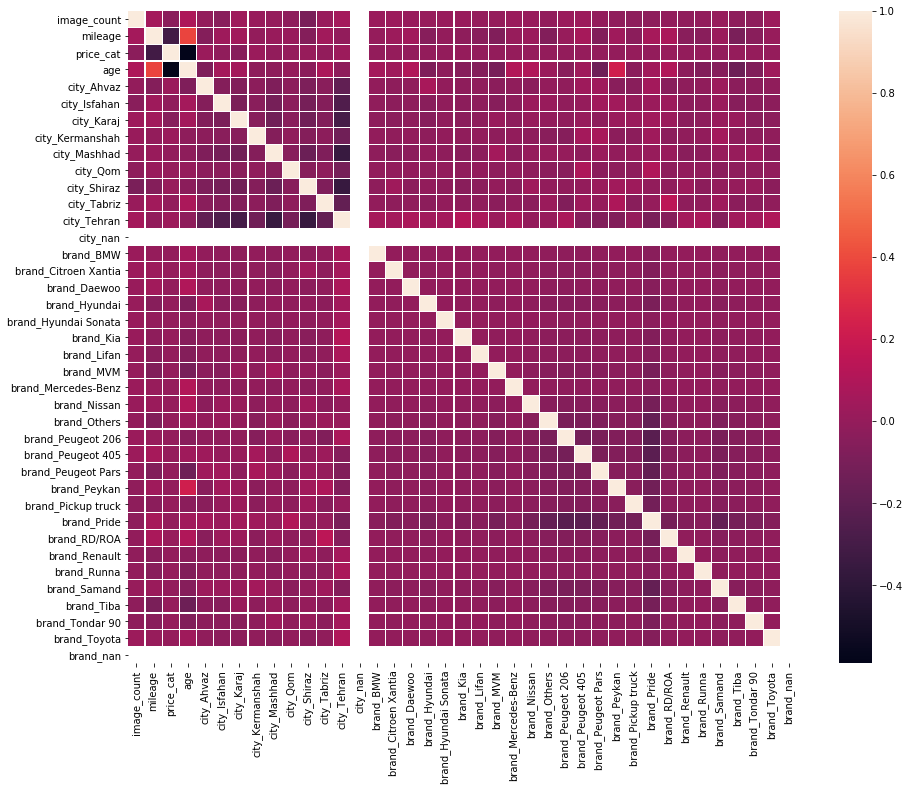

In [8]:
corr = cars.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr, ax=ax, linewidths=0.1)

# Random Forest train and test
split dataset into 4:1 and apply RF classifier

In [96]:
from sklearn.model_selection import train_test_split
X = cars.drop(columns=['price_cat'])
Y = cars['price_cat']

from sklearn.feature_selection import SelectPercentile, SelectKBest, chi2
percentile_best = 10
k_best = 3
# X_new = SelectPercentile(chi2, percentile=percentile_best).fit_transform(X, Y)
X_new = SelectKBest(chi2, k=k_best).fit_transform(X, Y)
print(X_new.shape)

X_test, X_train, Y_test, Y_train = train_test_split(X_new, Y, test_size=0.2)

from sklearn.ensemble import RandomForestClassifier

rf_depth = 4
clf = RandomForestClassifier(max_depth=rf_depth, n_estimators=100)
clf.fit(X_train, Y_train)

(103799, 3)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

##### accuracy

In [97]:
from sklearn.metrics import accuracy_score
Y_train_pred = clf.predict(X_train)
acc_train = accuracy_score(Y_train, Y_train_pred)
Y_test_pred = clf.predict(X_test)
acc_test = accuracy_score(Y_test, Y_test_pred)
print(' Model:      {}\n Max Depth:  {}\n label:      {}\n categories: {}\n Accuracy:   {:.2f}% @train\n Accuracy:   {:.2f}% @test\n '
      .format('Random Forest', rf_depth, 'price_cat', len(cars['price_cat'].unique()), acc_test*100, acc_train*100))

 Model:      Random Forest
 Max Depth:  4
 label:      price_cat
 categories: 3
 Accuracy:   65.69% @train
 Accuracy:   66.00% @test
 


##### confusion matrix

In [98]:
from sklearn.metrics import confusion_matrix
confusion_matrix_random_forest = pd.DataFrame(confusion_matrix(Y_test, Y_test_pred))
confusion_matrix_random_forest
# this pandas output looks better tha the default!

0      1      2
0  19838   4997   2516
1   5575  13745   8105
2   1514   5784  20965

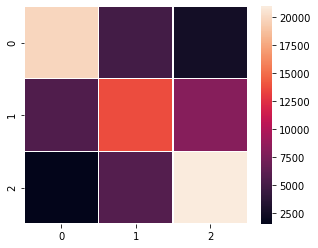

In [99]:
f, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(confusion_matrix_random_forest, ax=ax, linewidths=0.1)

### Classification Report

In [100]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_test_pred, target_names=['1', '2', '3']))

              precision    recall  f1-score   support

           1       0.74      0.73      0.73     27351
           2       0.56      0.50      0.53     27425
           3       0.66      0.74      0.70     28263

    accuracy                           0.66     83039
   macro avg       0.65      0.66      0.65     83039
weighted avg       0.65      0.66      0.65     83039



['0', '1', '2']

In [120]:
# from sklearn.datasets import load_iris
# iris = load_iris()

# # Model (can also use single decision tree)
# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(n_estimators=10)

# # Train
# model.fit(iris.data, iris.target)
# # Extract single tree
# estimator = model.estimators_[5]

target_names = list(map(str, cars['price_cat'].unique())) # ['1', '2', '3']
feature_names = [('k_best_'+str(i)) for i in range(X_new.shape[1])] # cars.drop(columns=['price_cat']).columns.values
estimator = clf.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# # Convert to png using system command (requires Graphviz)
# from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree.png')

### Precision Recall

# XGBoost

In [176]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, Y_train)
dtest  = xgb.DMatrix(X_test , Y_test )

param = {'max_depth': 5, 'eta': 1}
param['nthread'] = 4
# param['eval_metric'] = 'auc'

evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)
# bst.save_model('0001.model')

[0]	eval-rmse:0.60067	train-rmse:0.59617
[1]	eval-rmse:0.60037	train-rmse:0.59302
[2]	eval-rmse:0.60110	train-rmse:0.59142
[3]	eval-rmse:0.60196	train-rmse:0.59013
[4]	eval-rmse:0.60236	train-rmse:0.58918
[5]	eval-rmse:0.60352	train-rmse:0.58753
[6]	eval-rmse:0.60418	train-rmse:0.58681
[7]	eval-rmse:0.60428	train-rmse:0.58644
[8]	eval-rmse:0.60482	train-rmse:0.58547
[9]	eval-rmse:0.60510	train-rmse:0.58505


In [177]:
Y_train_pred_XGB = bst.predict(dtrain)
Y_train_pred_XGB = list(map(lambda y: int(round(y)), Y_train_pred_XGB))

from sklearn.metrics import accuracy_score
acc_score = accuracy_score(Y_train, Y_train_pred_XGB)
print('The accuracy of "XGBoost" model for TRAIN on price (categorized into {} classes) is "{:.2f}%"'.format(len(Y_train.unique()), acc_score*100))

The accuracy of "XGBoost" model for TRAIN on price (categorized into 3 classes) is "64.31%"


In [178]:
Y_test_pred_XGB = bst.predict(dtest)
Y_test_pred_XGB = list(map(lambda y: int(round(y)), Y_test_pred_XGB))

from sklearn.metrics import accuracy_score
acc_score = accuracy_score(Y_test, Y_test_pred_XGB)
print('The accuracy of "XGBoost" model for TEST on price (categorized into {} classes) is "{:.2f}%"'.format(len(Y_test.unique()), acc_score*100))

The accuracy of "XGBoost" model for TEST on price (categorized into 3 classes) is "62.84%"
